### DSCI 310 - Project Milestone 1

# Classifying Music Genres Using Spotify Song Features

**To Do**

- Methods and Analysis
- Discussion
- maybe pull comments in code blocks to text blocks to illustrate code?

In [3]:
# Load necessary packages 
library(tidyverse)
library(repr)
library(tidymodels)
library(RCurl)
library(kknn)
library(cowplot)

# Set default rows displayed for dataframes
options(repr.matrix.max.rows = 6)

# Set seed for reproducibility 
set.seed(1)

── Attaching packages ──────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ─────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ─────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖

## Summary - pls edit

In this project, we aim to answer the question of whether Spotify's audio features can be used to predict song genres. We use a KNN classification model that we evaluate using ROC/AUC, and produce visualizations and statistics to summarize our findings. 

## Intro

Music recommendation systems have experienced rapid growth in the past decade in terms both of the increasingly influencial role they play in media consumption, and the research that is invested in improving these algorithms. Despite the sophisticated techniques and ample data available today, reports of music genre classification difficult show a wide variety of results, in part due to the plethora of possible features to classify a song on (Singh et al., 2022).

Projects involving deep learning have shown a wide variety of results with often limited success (Pelchet et al., 2020), while traditional machine learning classification based on musical characteristics (such as tempo, pitch, chord progression) seem to be relatively accurate (Ndou et al., 2021). However, these approaches to classification are distinctly different from that of Spotify, one of the most prevalent streaming services today that boasts an impressive recommendation algorithm. Rather than conforming to genre classification, the Spotify algorithm empahsizes personlized recommendations for each user, introducing a certain amount of bias that complicates the problem even further.

Interestingly enough, Spotify has been so proficient in tailoring their algorithm for their users' listening habits that they are facing critiques for decreasing exposure and discoverability of diverse music genres (Pell, 2017). Although they have released their database of songs for public use via Web API ,and even made their own custom audio features available (eg. speechiness, liveliness, etc.), there is still relatively little detail on how these features are used in their algorithm.

Because Spotify's audio features for music personalization vary so much from what is commonly selected for classification rooted in music theory yet are so relevant in music personalization, we wonder how these features may perform for a the slightly different but very related task of genre classification.

**Our goal is to discover how well Spotify's custom audio features are able to predict common genres of music.**

## The Dataset

We will be using the *Spotify Songs* dataset obtained here: https://github.com/dliu0049/tidytuesday_wc/tree/master/data/2020/2020-01-21 .

It consists of 23 different features, including a genre label and audio features for each song.

In [4]:
# Read the data from the web into jupyter
x <- getURL("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv")
song_data <- read.csv(text = x)

In [5]:
# Ran once to write the data into a local folder, don't need to run again
# write.csv(song_data,"data/spotify_songs.csv")

In [6]:
# Overview of the original dataset
song_data

track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,⋯,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxury Remix,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury Remix],2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,⋯,6,-2.634,1,0.0583,0.1020,0.00e+00,0.0653,0.518,122.036,194754
0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,⋯,11,-4.969,1,0.0373,0.0724,4.21e-03,0.3570,0.693,99.972,162600
1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,⋯,1,-3.432,0,0.0742,0.0794,2.33e-05,0.1100,0.613,124.008,176616
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,14,0ltWNSY9JgxoIZO4VzuCa6,Sweet Surrender (Radio Edit),2014-04-21,â™¥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,⋯,6,-4.899,0,0.0481,0.108000,1.11e-06,0.150,0.4360,127.989,210112
2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,15,1fGrOkHnHJcStl14zNx8Jy,Only For You (Remixes),2014-01-01,â™¥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,⋯,2,-3.361,1,0.1090,0.007920,1.27e-01,0.343,0.3080,128.008,367432
29zWqhca3zt5NsckZqDf6c,Typhoon - Original Mix,Julian Calor,27,0X3mUOm6MhxR7PzxG95rAo,Typhoon/Storm,2014-03-03,â™¥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,⋯,5,-4.571,0,0.0385,0.000133,3.41e-01,0.742,0.0894,127.984,337500


## Preliminary Data Analysis

Here we tidy our data and select only the columns for our analysis. 

**Table 1.1** - Original dataset

To tidy the data, from `song_data` we first selected only the predicted feature `playlist_genre` and the predictor features that relate to the acoustic aspects of the songs. Then, the datatype of `playlist_genre` was converted from character to factor and the resulting dataframe was named `tidy_song_data`

In [7]:
# Tidy the data, only keep the relevant columns
tidy_song_data <- song_data |>
            select(playlist_genre, danceability:tempo)

# Change datatype of playlist_genre from character to factor in order for some of the functions to work later
tidy_song_data$playlist_genre <- as.factor(tidy_song_data$playlist_genre)

tidy_song_data

playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.00e+00,0.0653,0.518,122.036
pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,4.21e-03,0.3570,0.693,99.972
pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,2.33e-05,0.1100,0.613,124.008
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
edm,0.529,0.821,6,-4.899,0,0.0481,0.108000,1.11e-06,0.150,0.4360,127.989
edm,0.626,0.888,2,-3.361,1,0.1090,0.007920,1.27e-01,0.343,0.3080,128.008
edm,0.603,0.884,5,-4.571,0,0.0385,0.000133,3.41e-01,0.742,0.0894,127.984


**Table 1.2** - Tidy dataset

Next we seperated the `tidy_song_data` into a `training_song_data set` with which to build our classifier, and a `testing_song_data` set with which to evaluate it with later on. The ratio of the training/testing split is 75/25%, and the relative proportion of each `playlist_genre` category was preserved in each set.

In [8]:
# Split the data into training and testing sets at 75:25 ratio
set.seed(1) # Set the seed for reproducability

split_song_data <- initial_split(tidy_song_data, prop = 0.75, strata = playlist_genre)

# training set
training_song_data <- training(split_song_data)

# testing set
testing_song_data <- testing(split_song_data)

For preliminary data analysis, two things were checked, only using the `training_song_data`. First, the proportions of the `playlist_genre`, just to make sure the split divided it properly, and second, the amount of `NA` values in the dataset, which is important to ensure the set is suitable for analysis.

In [29]:
# Preliminary data analysis

# Get proportions of genres from tidy data
tidy_prop <- tidy_song_data |>
                      group_by(playlist_genre) |>
                      summarize(n = n()) |>
                      mutate(tidy_prop = 100*n/nrow(tidy_song_data))|>
                      select(playlist_genre, tidy_prop)

# Get proportions of genres from training data
song_proportions <- training_song_data |>
                      group_by(playlist_genre) |>
                      summarize(n = n()) |>
                      mutate(training_prop = 100*n/nrow(training_song_data))

# Combine dataframes to compare
df_list <- list(song_proportions, tidy_prop)      

df_list %>% reduce(full_join, by='playlist_genre')

playlist_genre,n,training_prop,tidy_prop
<fct>,<int>,<dbl>,<dbl>
edm,4532,18.40556,18.40526
latin,3866,15.70077,15.70067
pop,4130,16.77294,16.77276
r&b,4073,16.54144,16.54128
rap,4309,17.49990,17.50069
rock,3713,15.07940,15.07934


**Table 1.3.1** - Proportions of each genre in training set compared to tidy data

The proportions are about the same in both datasets

In [11]:
#Check number of missing values in each column of the table in the training data
num_na <- training_song_data|> 
            summarize_all(~sum(is.na(.))) 
num_na

playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0


**Table 1.3.2** - Preliminary data analysis 

There is no missing data in the dataset

For the preliminary data visualization, histograms were created comparing the audio features between each of the `playlist_genre` categories. 

**NOTE:** Presumably this can be done with less code (iterating ggplot histograms into a list) but it was tried and we could not get it to work 

**NOTE:** This cell may take around 20 seconds to run, if the graphs load in small the first time, run it again

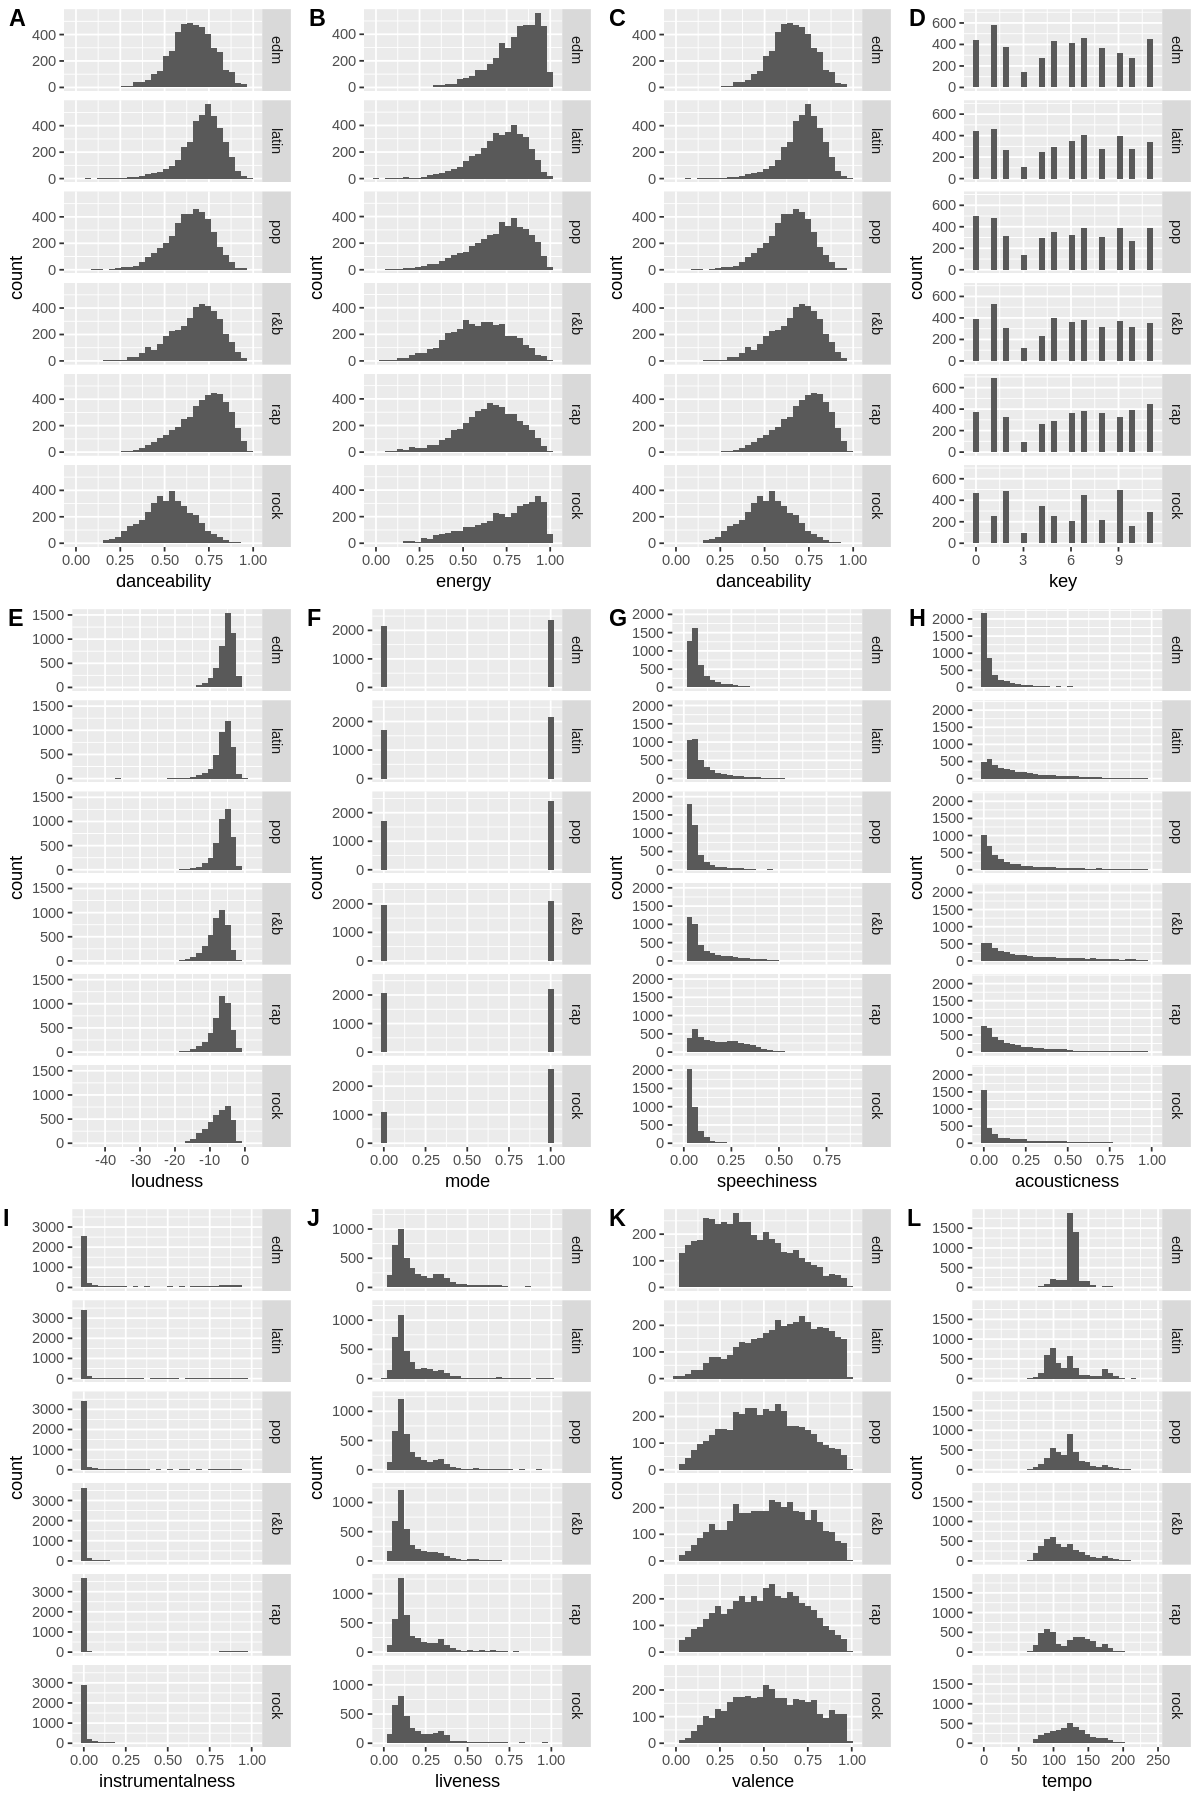

In [45]:
# Preliminary data visualization
# Histograms of each of the features that we are using, differentiated by labeled genre
danceability_hist <- ggplot(training_song_data, aes(x = danceability)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

energy_hist <- ggplot(training_song_data, aes(x = energy)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

danceability_hist <- ggplot(training_song_data, aes(x = danceability)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

key_hist <- ggplot(training_song_data, aes(x = key)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

loudness_hist <- ggplot(training_song_data, aes(x = loudness)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

mode_hist <- ggplot(training_song_data, aes(x = mode)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

speechiness_hist <- ggplot(training_song_data, aes(x = speechiness)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

acousticness_hist <- ggplot(training_song_data, aes(x = acousticness)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

instrumentalness_hist <- ggplot(training_song_data, aes(x = instrumentalness)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

liveness_hist <- ggplot(training_song_data, aes(x = liveness)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

valence_hist <- ggplot(training_song_data, aes(x = valence)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

tempo_hist <- ggplot(training_song_data, aes(x = tempo)) +
                            geom_histogram(bins=30) +
                            facet_grid(rows = "playlist_genre")

# Plot all the histograms together 
plot_grid(danceability_hist, energy_hist, danceability_hist, key_hist, loudness_hist, mode_hist, speechiness_hist, acousticness_hist, instrumentalness_hist, liveness_hist, valence_hist ,tempo_hist, ncol = 4, labels = "AUTO")
options(repr.plot.width = 15, repr.plot.height = 15)

**Figure 1.4** - Preliminary data visualization

The histograms above show that while the distributions of certain audio features in songs are similar between different genres, across all the features there are differences in the central tendency and that these differences may provide enough information to acheive a reasonable accuracy with the classifier

The next steps show the building of the classifier 

In [46]:
# Scale predictors, use standard recipe, setup knn_spec to tune for best k value
song_recipe <- recipe(playlist_genre ~ ., data = training_song_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

**NOTE:** The cell below will take around 5 minutes to load due to the size of the dataset

In [47]:
# Cross validating and finding the best hyperparameter for the model

set.seed(1) # Setting seed for reproducibility

# Trying 15 different k values, count by every 10 from 1 to 51
k_vals <- tibble(neighbors = seq(from = 1, to = 51, by = 10))

song_vfold <- vfold_cv(training_song_data, v = 5, strata = playlist_genre)

knn_results <- workflow() |>
  add_recipe(song_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = song_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

In [48]:
# Accuracy table for different k values
accuracies |>  arrange(desc(mean))

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,accuracy,multiclass,0.4849506,5,0.005409901,Preprocessor1_Model5
51,accuracy,multiclass,0.4847882,5,0.005032700,Preprocessor1_Model6
31,accuracy,multiclass,0.4843824,5,0.005472263,Preprocessor1_Model4
21,accuracy,multiclass,0.4793856,5,0.005437704,Preprocessor1_Model3
11,accuracy,multiclass,0.4730514,5,0.003223286,Preprocessor1_Model2
1,accuracy,multiclass,0.4209050,5,0.003307323,Preprocessor1_Model1


**Table 2.1** - Accuracy of the different k values

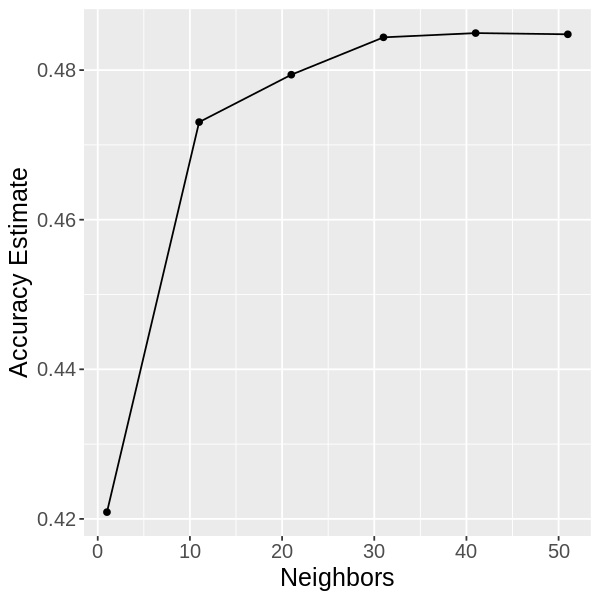

In [49]:
# Plot the different accuracies of k, 
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 15))

options(repr.plot.width = 5, repr.plot.height = 5)
accuracy_vs_k

**Figure 2.2** - Accuracies of the different k values

The k value that gives the most accuracy before diminishing returns is 11, with a accuracy of ~47.3

In [52]:
# Calculate accuracy of the model using the best k and cross-validation

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(song_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = song_vfold)

accuracy_value <- knn_fit |> 
  collect_metrics() 

In [53]:
# Display accuracy of the model
accuracy_value

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.4730514,5,0.003223286,Preprocessor1_Model1
roc_auc,hand_till,0.7747687,5,0.003256340,Preprocessor1_Model1


**Table 2.3** - Accuracy of the model on validation data

In [28]:
#test predictions using test-data
knn_fit <- workflow() |>
  add_recipe(song_recipe) |>
  add_model(knn_spec) |>
  fit(training_song_data)

song_test_predictions <- predict(knn_fit, testing_song_data) |>
  bind_cols(testing_song_data)

accuracy_only <- song_test_predictions |>
  metrics(truth = playlist_genre, estimate = .pred_class) |>
  filter(.metric == "accuracy")


confusion <- song_test_predictions |>
             conf_mat(truth = playlist_genre, estimate = .pred_class)

In [29]:
# Accuracy of the model on testing data
accuracy_only

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4684531


**Table 2.4** - Accuracy of model on testing data, slightly lower than on the validation data

In [30]:
# A table of predictions of the model
song_test_predictions

.pred_class,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pop,pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.00000,0.0653,0.518,122.036
latin,pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.00421,0.3570,0.693,99.972
edm,pop,0.449,0.856,5,-4.788,0,0.0623,0.1870,0.00000,0.1760,0.152,112.648
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
pop,edm,0.645,0.832,2,-5.595,1,0.0294,0.00106,2.64e-03,0.199,0.375,112.028
edm,edm,0.581,0.640,5,-8.367,1,0.0365,0.02660,0.00e+00,0.572,0.288,128.001
edm,edm,0.529,0.821,6,-4.899,0,0.0481,0.10800,1.11e-06,0.150,0.436,127.989


**Table 2.5** - Predictions on the data

In [31]:
# Confusion
confusion

          Truth
Prediction edm latin pop r&b rap rock
     edm   952   146 277  74 122  111
     latin 105   475 181 170 184   49
     pop   215   221 391 203 100  139
     r&b    60   178 190 483 207  126
     rap    81   178 114 296 771   39
     rock   98    91 224 132  53  774

**Table 2.6** - Confusion Matrix

In [18]:
# Data visualization 

In [19]:
# Forward Selection?

In [20]:
# Discussion

## References

*put into citation format later*

https://www.sciencedirect.com/science/article/pii/S0957417422003244?casa_token=AdbZPnVPOJcAAAAA:jtfvY-Wz8ZcDinlhpIrleJxF-nVV8Bti8sMUVNcyjH4kOASaYtUH6IRPVZRiRj_c_Q4C5RAd

https://ieeexplore.ieee.org/abstract/document/9165253?casa_token=jX_e2n4H3FwAAAAA:zENgEy_sQDHcPD7Ifh4O29JO6vNHfuVS6ikIPfLQoHJNVc77q1FALmmuEv2xC5cOnDYtroA

https://ieeexplore.ieee.org/abstract/document/9422487?casa_token=WddEEs16qrYAAAAA:XmtFuFcWv0jQoAeC1eBROFy7TSKogEKqGBIYpGg-4BROABjw7uIxBAEeE3A9odZbunCZEx0

https://www.diva-portal.org/smash/record.jsf?pid=diva2%3A1153904&dswid=8969

*unused links archive*

https://academic.oup.com/california-scholarship-online/book/19140

https://scholar.smu.edu/datasciencereview/vol5/iss3/3/